## PCLS: immune figures

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct

Running Scanpy 1.8.2, on 2022-11-13 16:15.


In [2]:
## path variables
adata_dir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/subsets/'
project_dir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/01_data/ASK_joint/'

In [3]:
## plotting variables
fig_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint/immune_subset/'
sc.settings.figdir = fig_dir
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir + '211201_immune_subset_NIKLAS_annotated.h5ad')

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 29408 × 15933
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'd_cluster', 'sub_leiden_1', 'sub_leiden_2', 'cell_type', 'cell_type_group'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'd_cluster_colors', 'dendrogram_cell_type', 'dendrogram_sub_leiden_1', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'sub_leiden_1_colors', 'sub_leiden_2_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

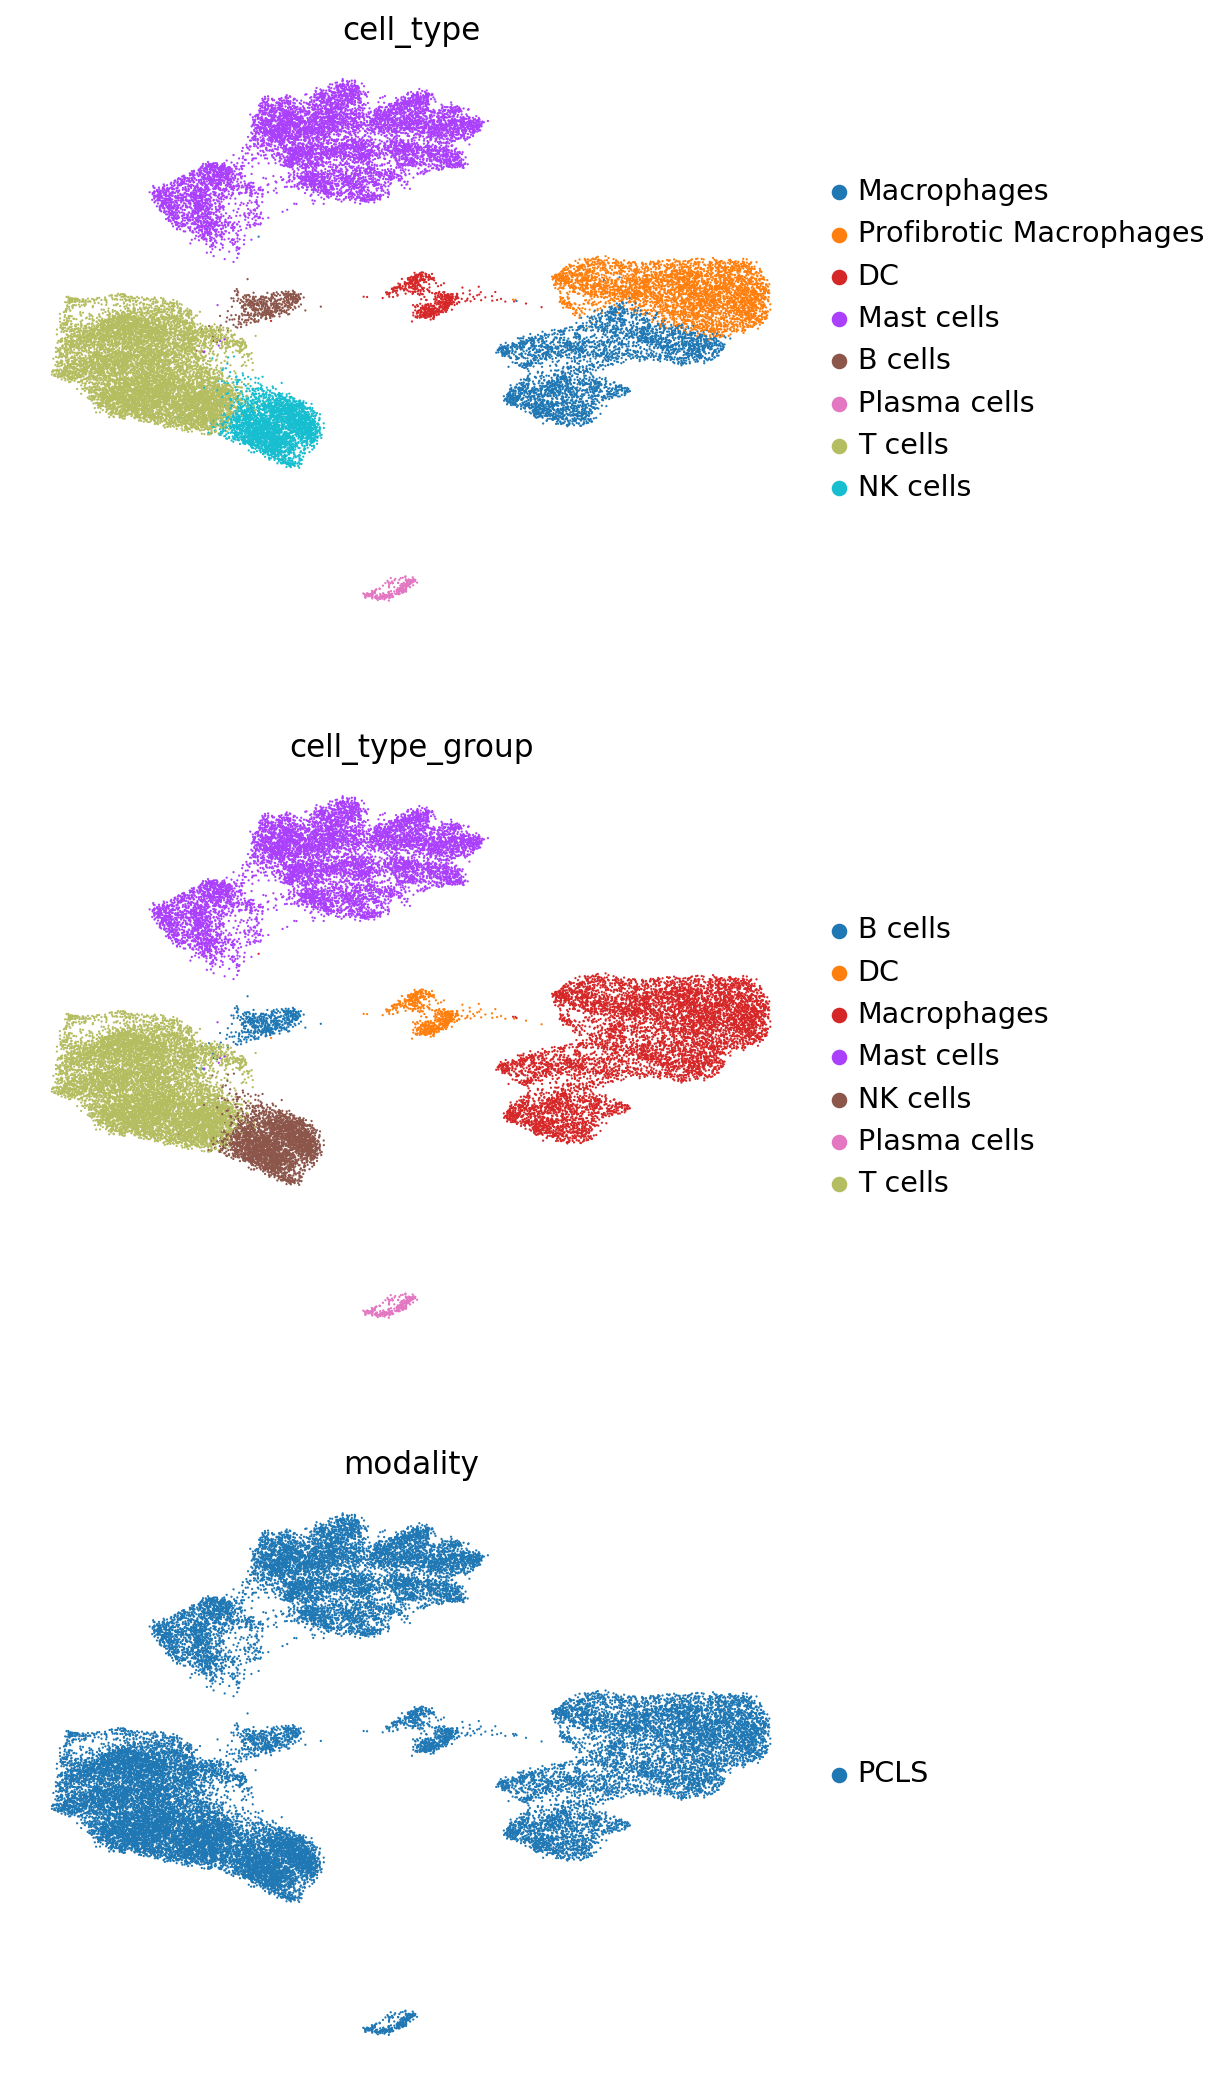

In [6]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type',
                           'cell_type_group',
                           'modality'], ncols = 1, frameon = False)

In [7]:
## subset data - we only want to visualize CC and FC
adata = adata[adata.obs.treatment.isin(['CC','FC'])].copy()

### Re-calculate HVGs

In [8]:
## delete all obs colums related to highly variable genes
del(adata.var['highly_variable'])
del(adata.var['highly_variable_nbatches'])
del(adata.var['highly_variable_intersection'])

In [9]:
## filter genes
sc.pp.filter_genes(adata, min_counts = 1)
sc.pp.filter_genes(adata, min_cells = 5)

filtered out 228 genes that are detected in less than 1 counts
filtered out 943 genes that are detected in less than 5 cells


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

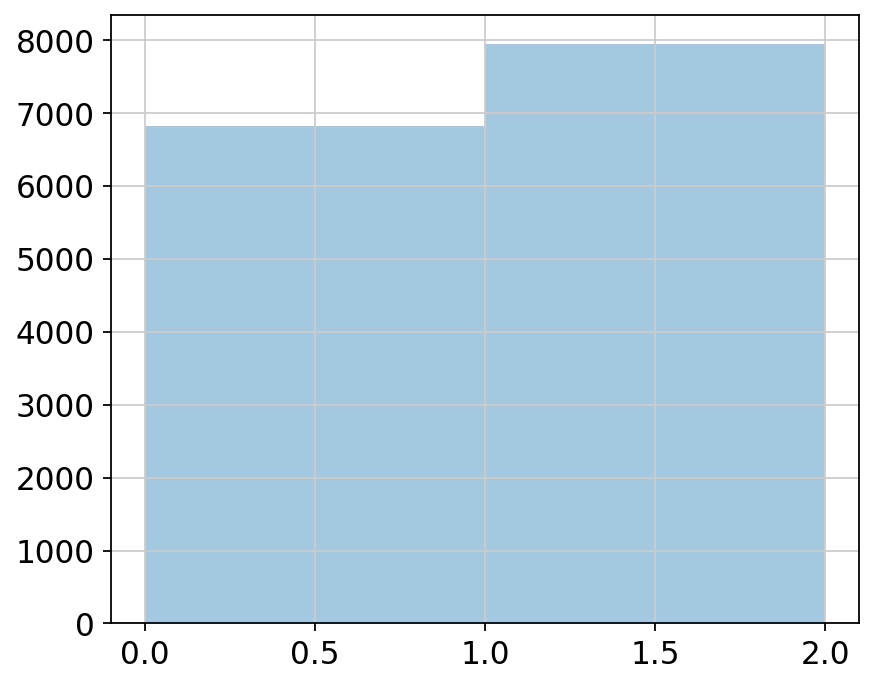

In [10]:
## compute HVGs per batch ('identifier') using seurat method
batch = 'patient'
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                                batch_key = batch, n_top_genes = 5000, n_bins = 20, flavor = 'seurat', 
                                subset = False)
vartab = pd.DataFrame(adata.var['highly_variable_nbatches'], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [11]:
## only consider a gene as variable if variable in at least 10 batches
thresh = 2
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print('%s Genes kept, variable in at least %s samples' %(len(hvgs), thresh))

2060 Genes kept, variable in at least 2 samples


In [12]:
## remove cell cycle genes (MOUSE) from list of HVGs
all_cc_genes = pd.read_table('/home/niklas/data/gene_lists/macosko_cell_cycle_genes.txt', header=0)
cc_genes = np.concatenate([all_cc_genes['IG1.S'], all_cc_genes['S'], all_cc_genes['G2.M'], all_cc_genes['M'], all_cc_genes['M.G1']]).astype(str)
cc_genes = [cc_genes[i] for i in np.arange(0,len(cc_genes))]
hvgs = np.setdiff1d(hvgs, cc_genes)

In [13]:
## set HVGs
adata.var['highly_variable'] = [g in hvgs for g in adata.var_names]
## no. of resulting HVGs
sum(adata.var['highly_variable'])

1975

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


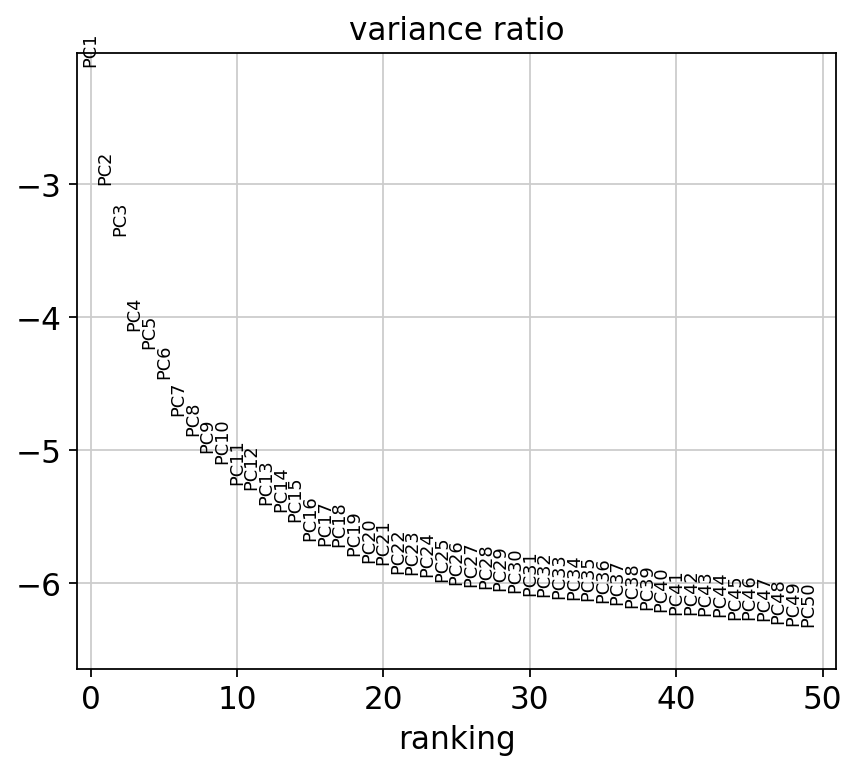

In [14]:
## PCA
sc.pp.pca(adata, use_highly_variable = True)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


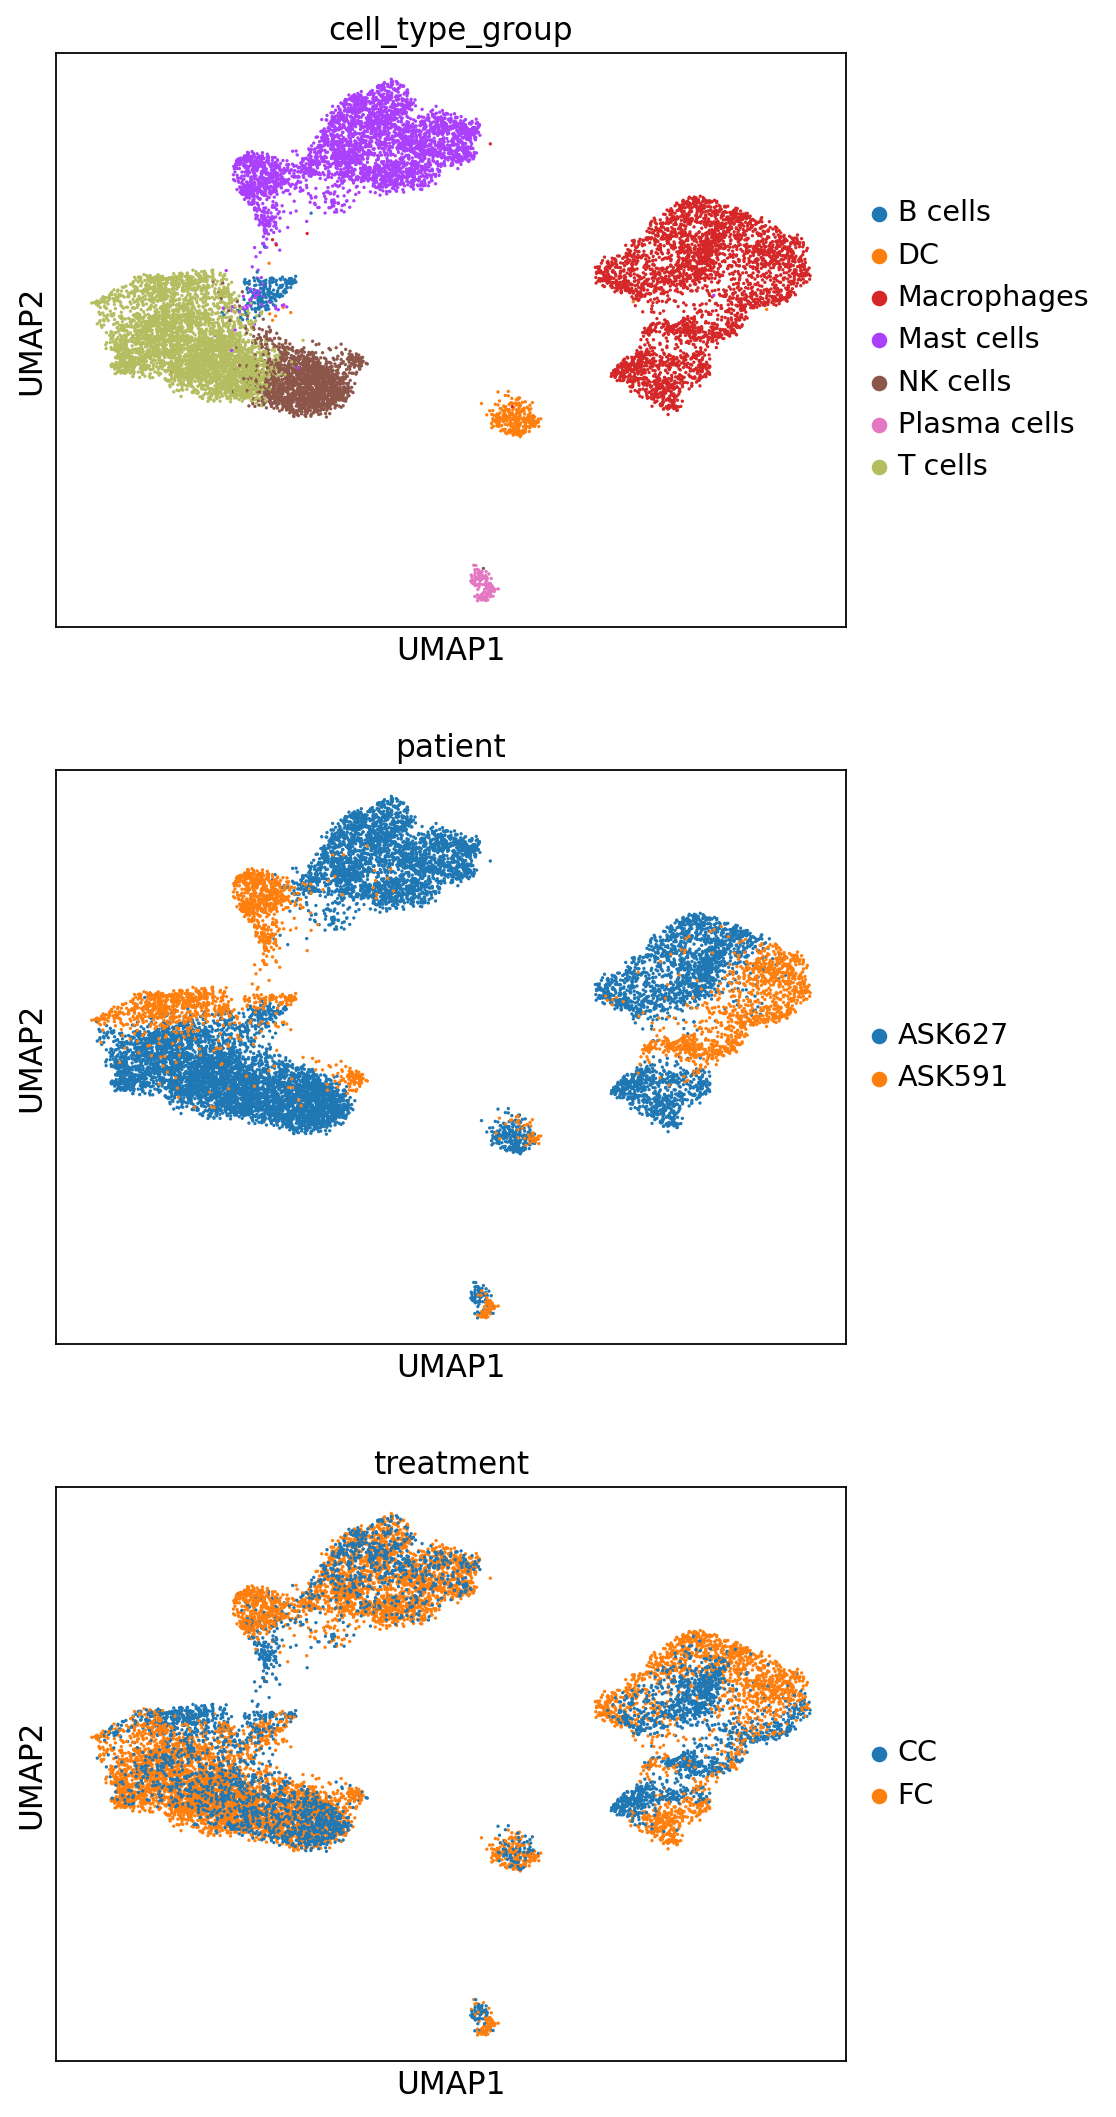

In [15]:
## graph based clustering
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 50)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['cell_type_group',
                           'patient',
                           'treatment'], ncols = 1)

### Save figures

In [16]:
treatment_colors = {'CC' : '#87CEFA', # CC
                    'FC' : '#32145E', # FC
                    'FC+Nintedanib' : '#D03833', # Nintedanib
                    'FC+CMP4' : '#F6991C', # CMP4
                   }

In [17]:
ct_colors = ['#E41A1C','#377EB8','#4DAF4A','#984EA3','#FF7F00','#FFFF33','#F781BF','#00FFFF']

In [18]:
def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())

In [19]:
adata.obs['cell_type'].cat.categories

Index(['Macrophages', 'Profibrotic Macrophages', 'DC', 'Mast cells', 'B cells',
       'Plasma cells', 'T cells', 'NK cells'],
      dtype='object')

In [20]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories(['Macrophages',
                                                                        'Profibrotic Macrophages',
                                                                        'DC',
                                                                        'Mast cells',
                                                                        'B cells',    
                                                                        'Plasma cells',
                                                                        'T cells',
                                                                        'NK cells'   
])

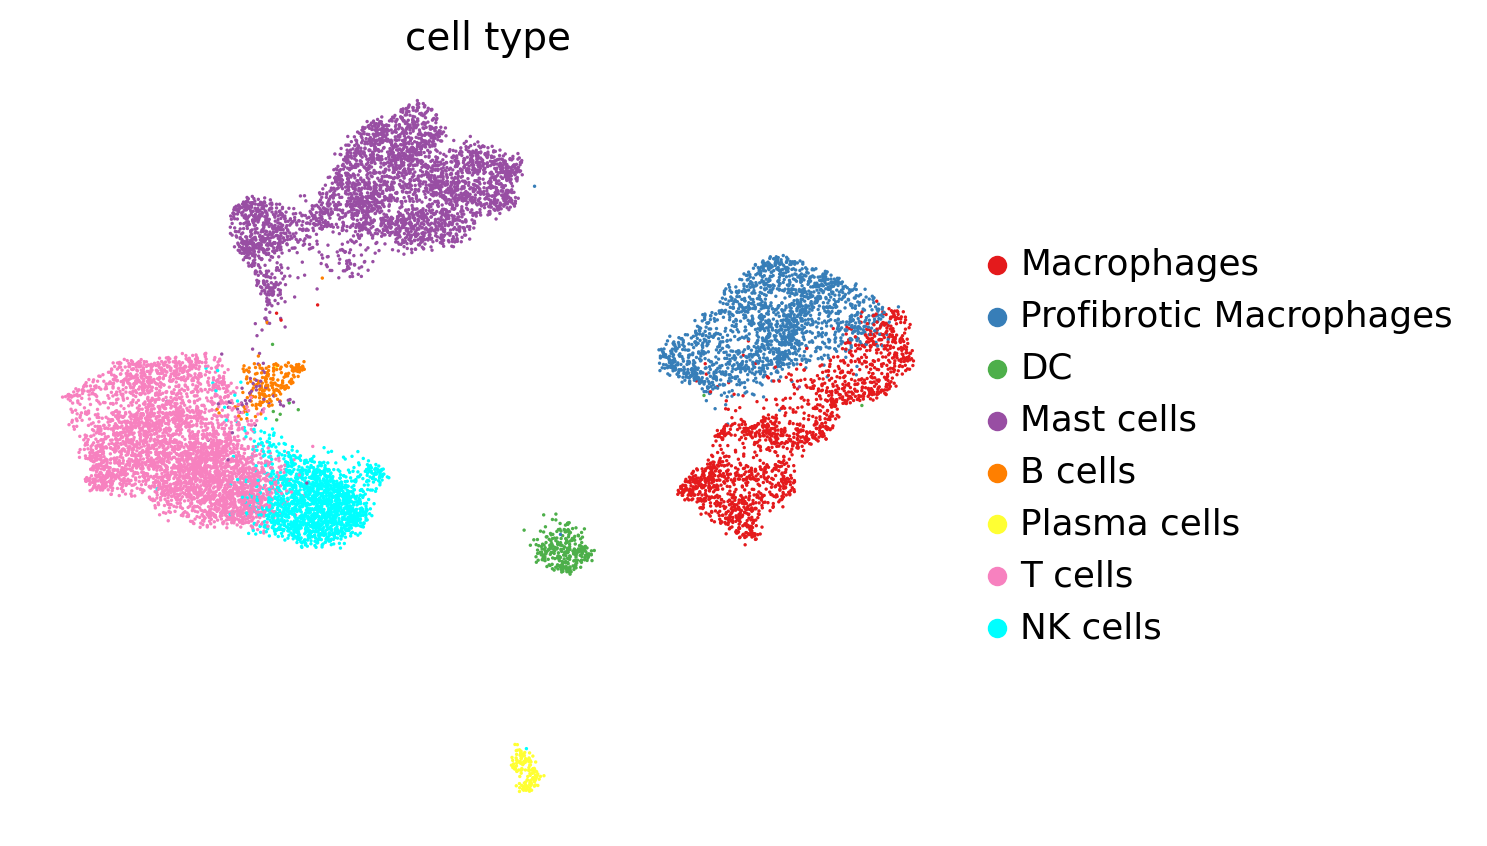

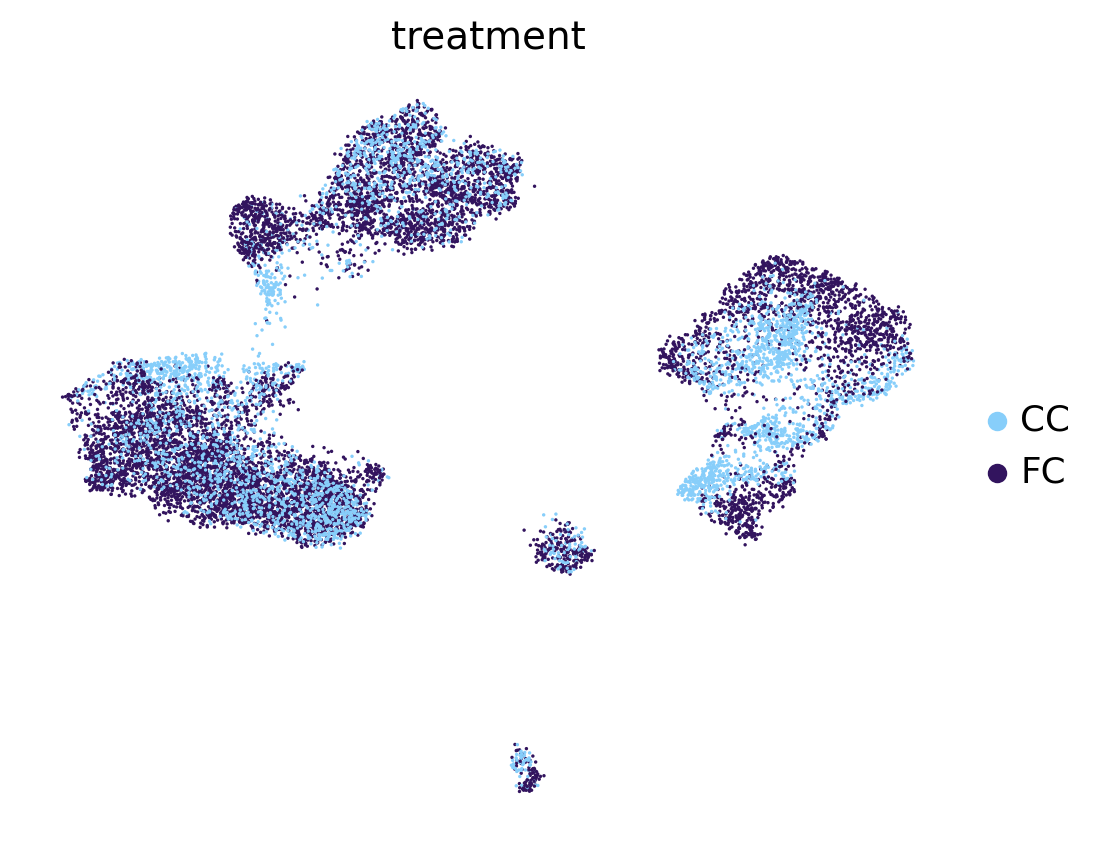

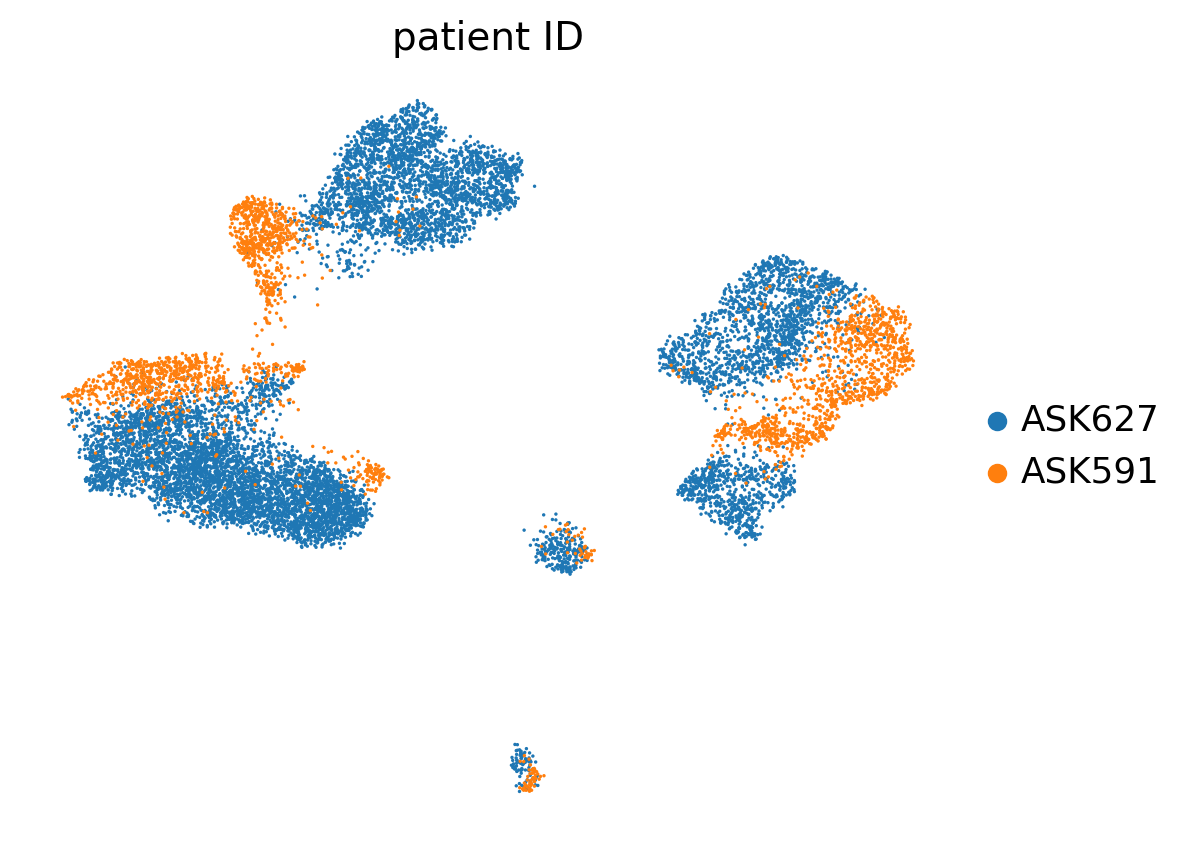

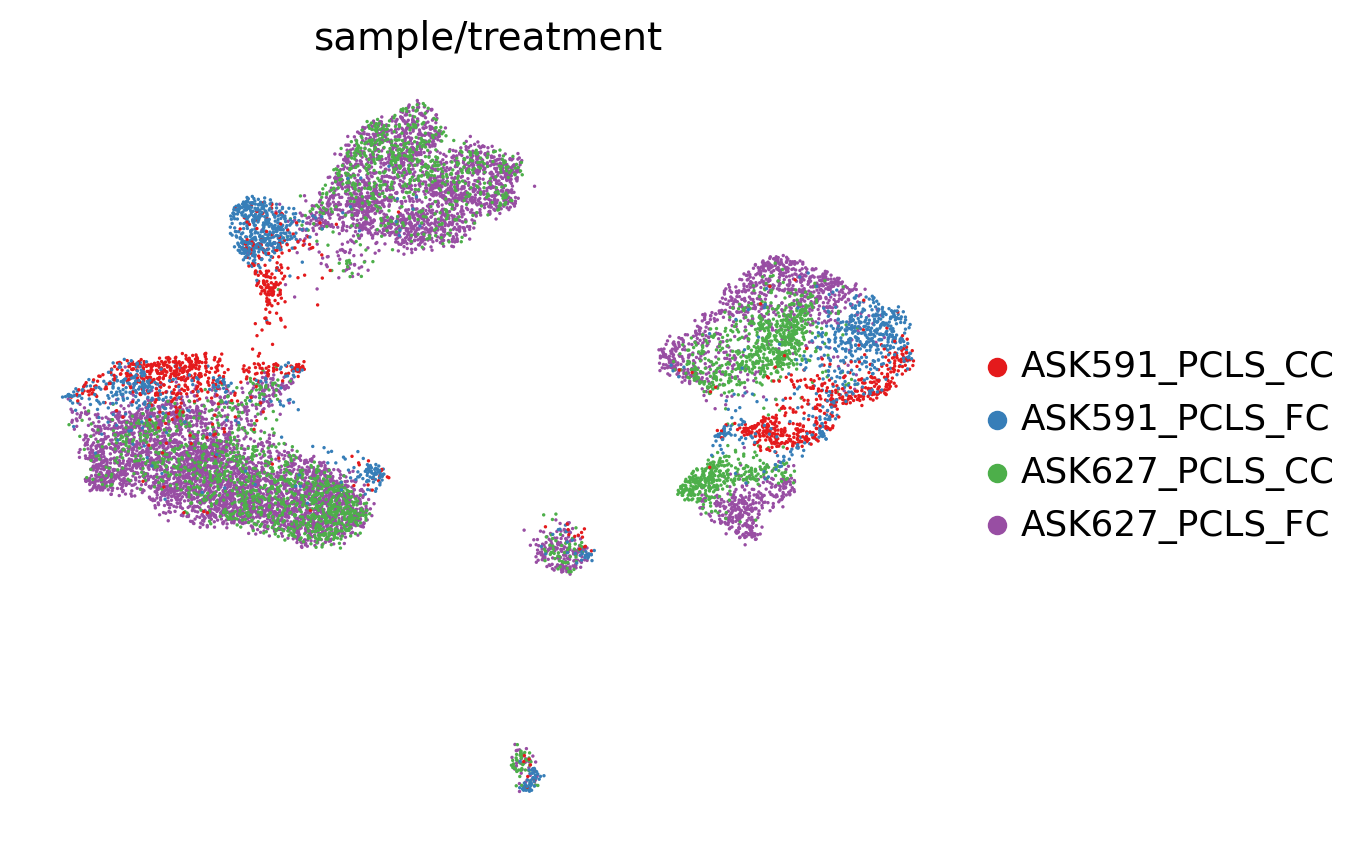

In [21]:
## cell type
sc.pl.umap(adata, color = ['cell_type'], title = 'cell type', frameon = False,
           palette = ct_colors,
           ax = mysize(6, 5, 100), size = 6, save = '_celltype.pdf')
## treatment
sc.pl.umap(adata, color = ['treatment'], title = 'treatment', frameon = False, 
           palette = treatment_colors, 
           ax = mysize(6, 5, 100), size = 6, save = '_treatment.pdf')
## patient / sample ID
sc.pl.umap(adata, color = ['patient'], title = 'patient ID', frameon = False,
           ax = mysize(6, 5, 100), size = 6, save = '_ASK_identifier.pdf')                           
## sample/treament
sc.pl.umap(adata, color = ['name'], title = 'sample/treatment', frameon = False,
           palette = ct_colors,
           ax = mysize(6, 5, 100), size = 6, save = '_sample_treatment.pdf')

In [22]:
## frequency table
xlabel = 'name'
cell_types_label = 'cell_type'
cols = adata.uns['%s_colors' %cell_types_label]
celltypes = adata.obs[cell_types_label].cat.categories

relFreqs = sct.calc.relative_frequencies(adata, group_by = cell_types_label, xlabel = xlabel, condition = None)
relFreqs.head(2)

,Macrophages,Profibrotic Macrophages,DC,Mast cells,B cells,Plasma cells,T cells,NK cells,name
muc24271,0.290495,0.125837,0.021419,0.313253,0.012048,0.030790,0.153949,0.052209,ASK591_PCLS_FC
muc24272,0.401168,0.010842,0.012510,0.155129,0.052544,0.006672,0.341952,0.019183,ASK591_PCLS_CC


In [23]:
order = ['ASK591_PCLS_CC',
         'ASK591_PCLS_FC',
         'ASK627_PCLS_CC',
         'ASK627_PCLS_FC'
        ]

Saving Figure to /home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/AS
K_joint/immune_subset/rel_freqs.pdf

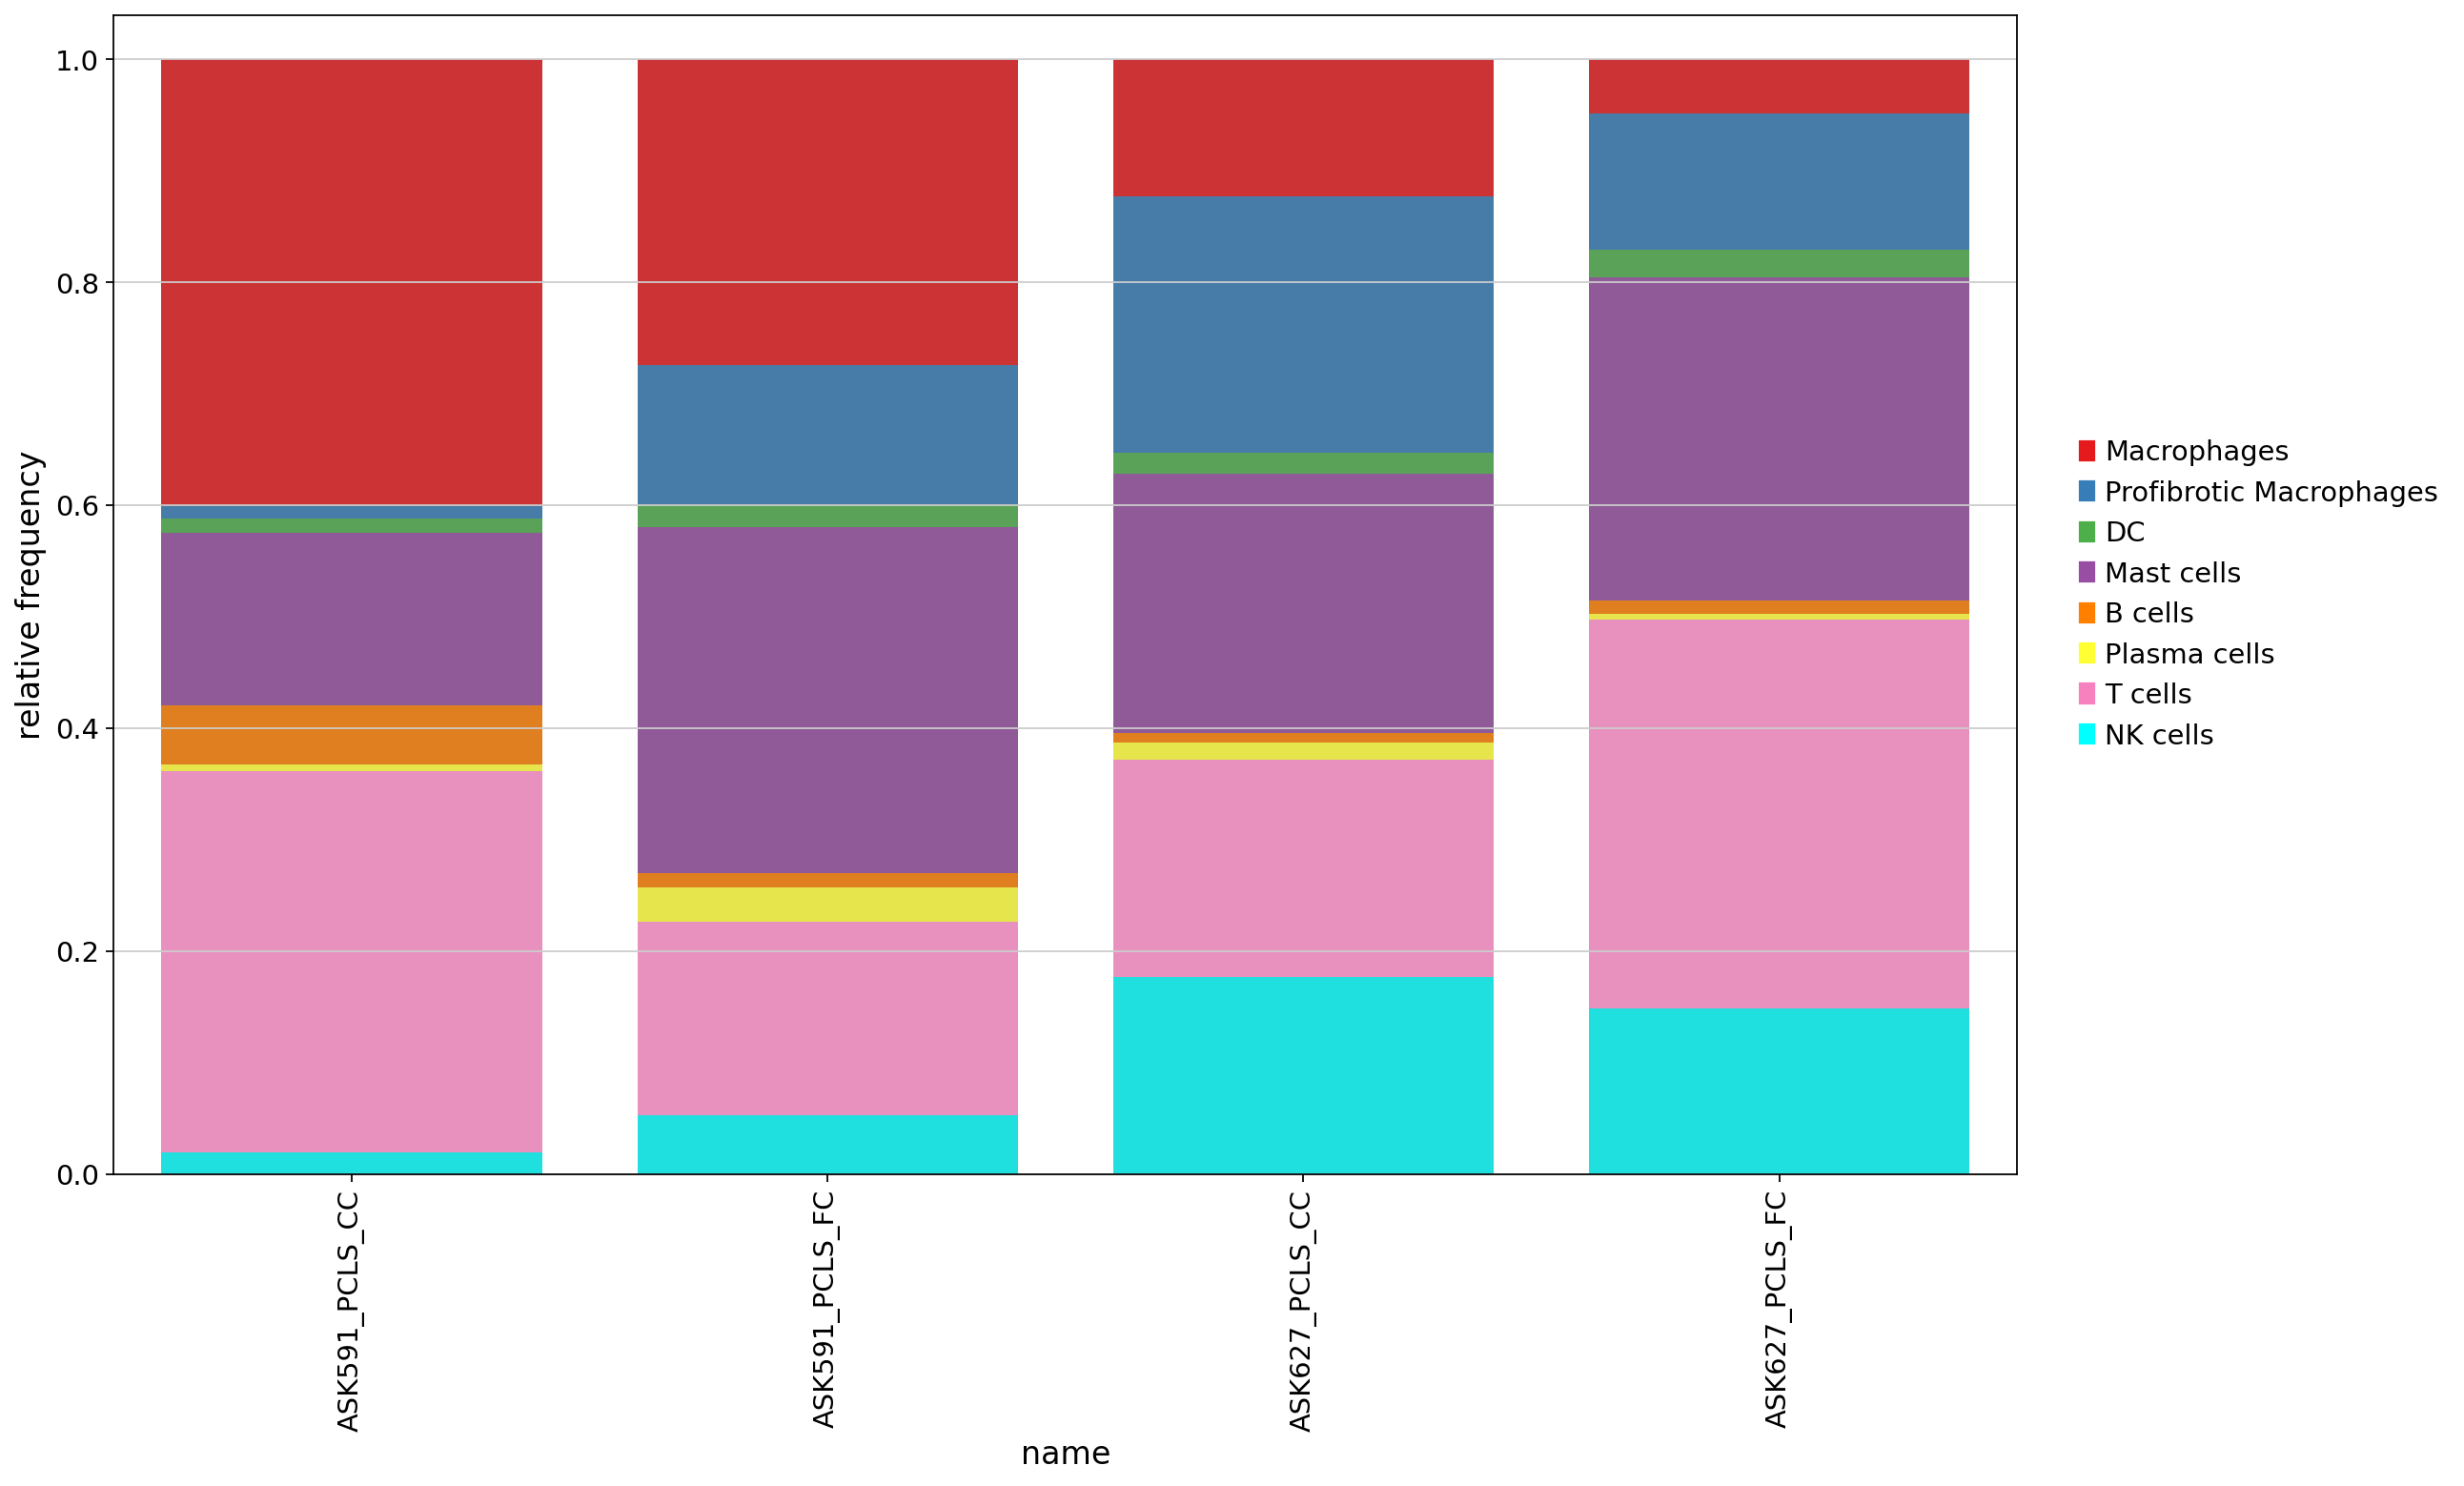

In [24]:
## cell type frequencies per treatment category
sct.plot.cluster_composition_stacked_barplot(relFreqs, xlabel = xlabel, figsize = (16,10), order = order,
                              colors = list(cols), width = 0.8,
                              save = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint/immune_subset/rel_freqs.pdf')

In [25]:
## automated heatmap - based on scanpy's score, but we will use top markers based on score and log2FC
sc.tl.dendrogram(adata, groupby = 'cell_type')
sc.tl.rank_genes_groups(adata, groupby = 'cell_type', groups = 'all', use_raw = True, method = 'wilcoxon', n_genes=500)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


In [26]:
## create marker table
result = adata.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
    current = pd.DataFrame({'gene': result['names'][cluster], 'score': result['scores'][cluster],
                            'logfoldchange': result['logfoldchanges'][cluster], 'pval': result['pvals'][cluster],
                            'pval_adj': result['pvals_adj'][cluster], 'cell_type': cluster})
    allMarkers.append(current)
allMarkers = pd.concat(allMarkers)
allMarkers.head()

,gene,score,logfoldchange,pval,pval_adj,cell_type
0,MS4A7,55.760208,4.910731,0.0,0.0,Macrophages
1,PSAP,54.142342,3.950175,0.0,0.0,Macrophages
2,GRN,52.681820,4.371358,0.0,0.0,Macrophages
3,SDCBP,51.625698,3.568717,0.0,0.0,Macrophages
4,CD68,51.531303,3.976086,0.0,0.0,Macrophages


In [27]:
## sort marker gene table by log FC and adjusted FC
allMarkers = allMarkers.sort_values(['cell_type','logfoldchange','score'], ascending=[True,False,True])
allMarkers.head()

,gene,score,logfoldchange,pval,pval_adj,cell_type
239,FCRL1,3.000825,10.593407,2.692490e-03,5.523425e-02,B cells
258,TCL1A,2.889999,10.588835,3.852436e-03,7.259874e-02,B cells
1,MS4A1,17.691580,10.026063,4.869116e-70,4.399977e-66,B cells
77,PAX5,8.308608,10.015105,9.683104e-17,1.590934e-14,B cells
42,BANK1,11.537490,8.958809,8.538012e-31,2.911462e-28,B cells


In [28]:
## save marker table
out_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/01_data/'
allMarkers.to_csv(out_dir + '220128_PCLS_human_ASK_joint_immune_marker_table.csv', index = False)

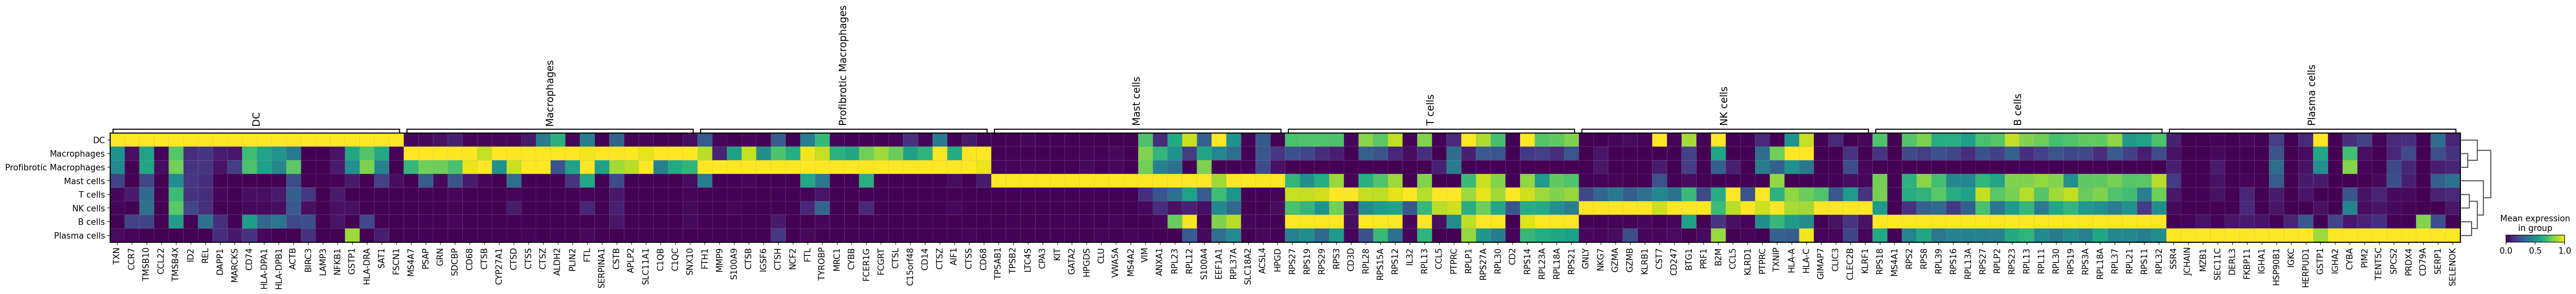

In [29]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes = 20, standard_scale = 'var', save= 'auto_markers.pdf')

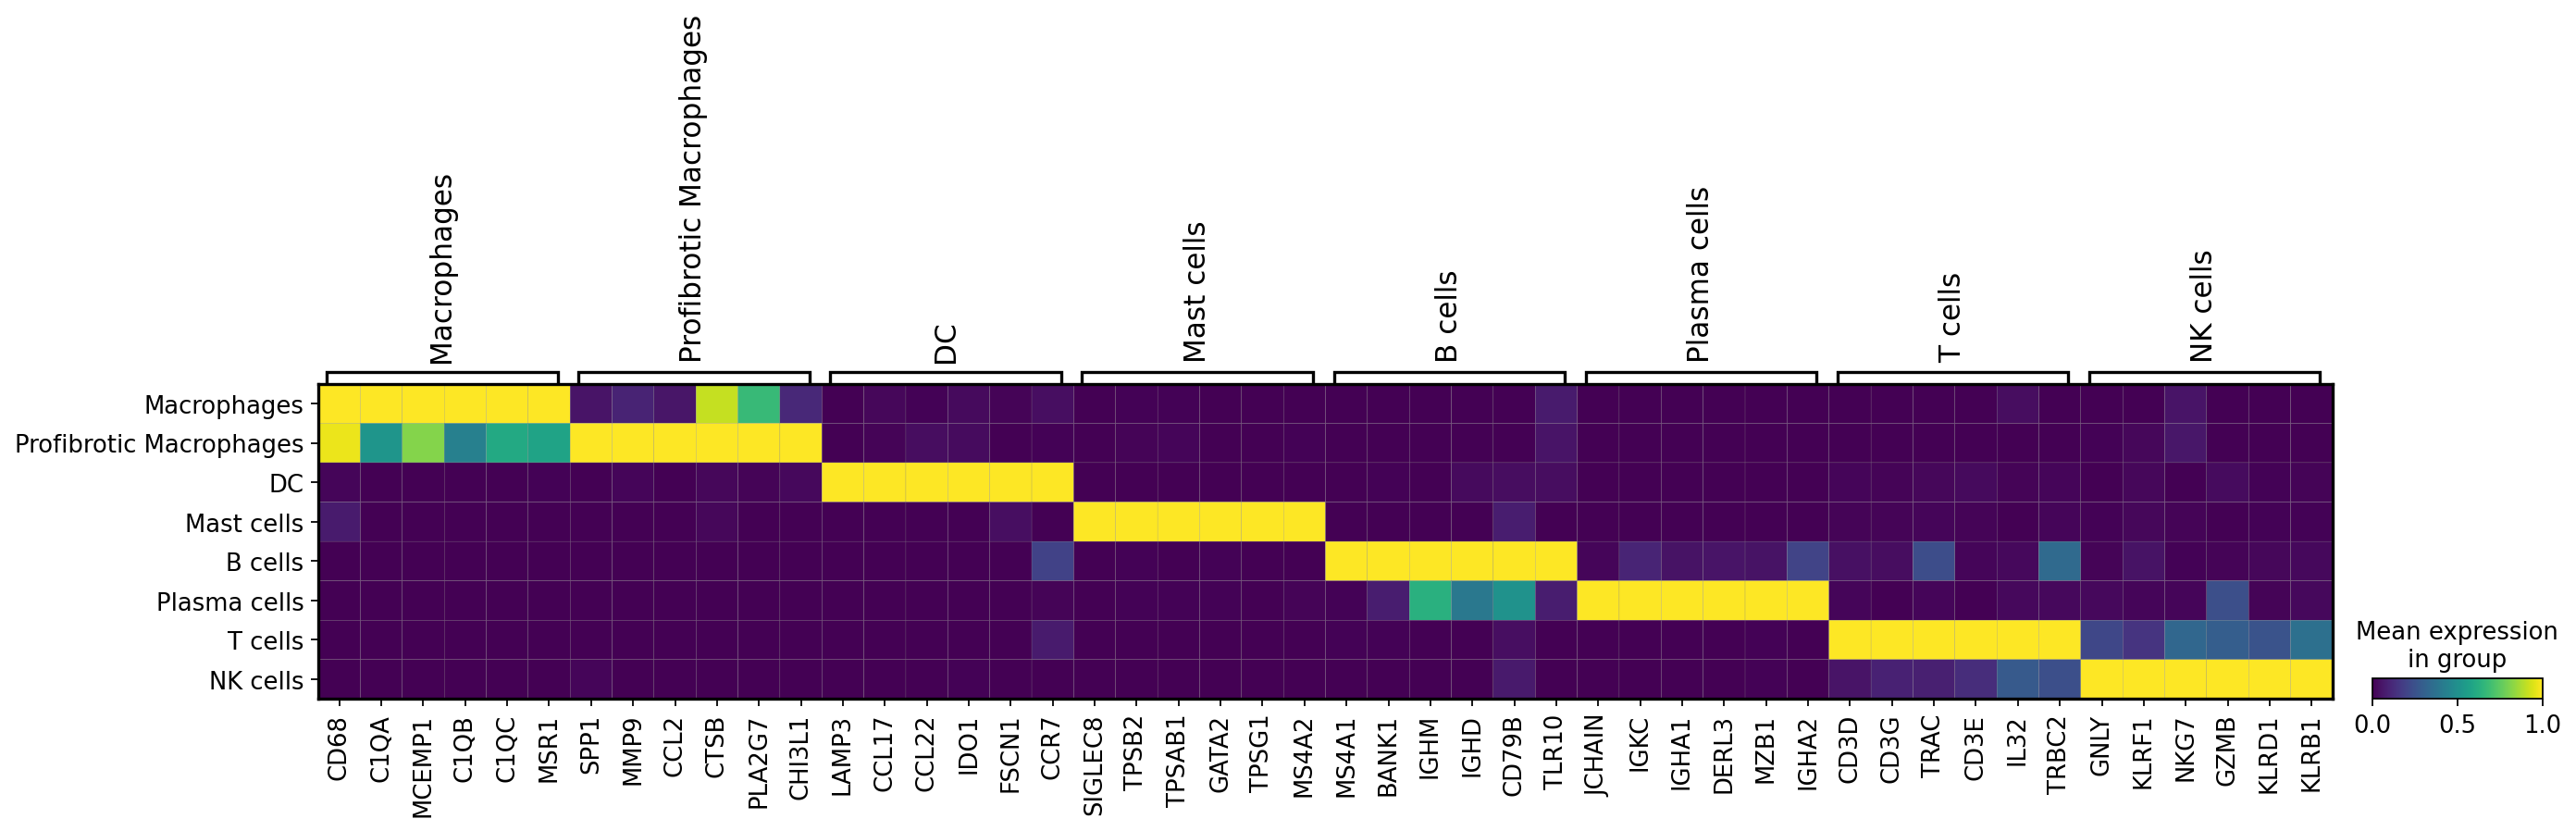

In [30]:
## custom heatmap
# matrixplot with marker genes
celltype_markers={'Macrophages' : ['CD68','C1QA','MCEMP1','C1QB','C1QC','MSR1'],
                  'Profibrotic Macrophages' : ['SPP1','MMP9','CCL2','CTSB','PLA2G7','CHI3L1'],
                  'DC' : ['LAMP3','CCL17','CCL22','IDO1','FSCN1','CCR7'],
                  'Mast cells' : ['SIGLEC8','TPSB2','TPSAB1','GATA2','TPSG1','MS4A2'],
                  'B cells' : ['MS4A1','BANK1','IGHM','IGHD','CD79B','TLR10'],
                  'Plasma cells' : ['JCHAIN','IGKC','IGHA1','DERL3','MZB1','IGHA2'],
                  'T cells' : ['CD3D','CD3G','TRAC','CD3E','IL32','TRBC2'],
                  'NK cells' : ['GNLY','KLRF1','NKG7','GZMB','KLRD1','KLRB1']             
}  
sc.pl.matrixplot(adata, celltype_markers, groupby = 'cell_type',standard_scale='var', dendrogram=False,
                     save='curated_markers.pdf' )

### Scorings: profibrotic Macrophage signature

In [31]:
macs = adata[adata.obs.cell_type_group.isin(['Macrophages'])]

In [32]:
marker_folder = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/01_data/marker_table/220111_CPC_IPF_reference_immune_markers_table_celltype.csv'
marker_table = pd.read_csv(marker_folder, sep = ',', index_col = None)
marker_table.head(5)

,gene,score,logfoldchange,pval,pval_adj,cell_type
0,FABP4,277.07834,7.923411,0.0,0.0,AM
1,GPD1,114.62699,7.844736,0.0,0.0,AM
2,SERPING1,222.64713,7.186562,0.0,0.0,AM
3,PPIC,124.47093,6.978579,0.0,0.0,AM
4,LGALS3BP,201.26636,6.512743,0.0,0.0,AM


In [33]:
marker_table['cell_type'].value_counts()

AM                         500
B cells                    500
IM                         500
Mast cells                 500
Monocytes                  500
NK cells                   500
Plasma cells               500
Profibrotic Macrophages    500
T cells                    500
cDC                        500
pDC                        500
Name: cell_type, dtype: int64

In [34]:
## what to score 
cell_type = 'Profibrotic Macrophages'
s_name = 'Profibrotic Macrophages signature'

In [35]:
score_genes = marker_table[marker_table['cell_type'] == cell_type]
score_genes = score_genes[score_genes['logfoldchange'] > 0.5]
#score_genes = score_genes[score_genes['pct_background'] < 0.25] ## few marker genes appeared to be that specific, keeping this threshold resulted in zero marker genes

In [36]:
score_genes_list = score_genes['gene'].to_list()
len(score_genes_list)

500

In [37]:
sc.tl.score_genes(macs, gene_list = score_genes_list, score_name = s_name)

computing score 'Profibrotic Macrophages signature'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'Profibrotic Macrophages signature', score of gene set (adata.obs).
    923 total control genes are used. (0:00:00)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving to /home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/02_figures/ASK_joint
/immune_subset/boxplot_profibrotic_macrophage_score_treatment.pdf

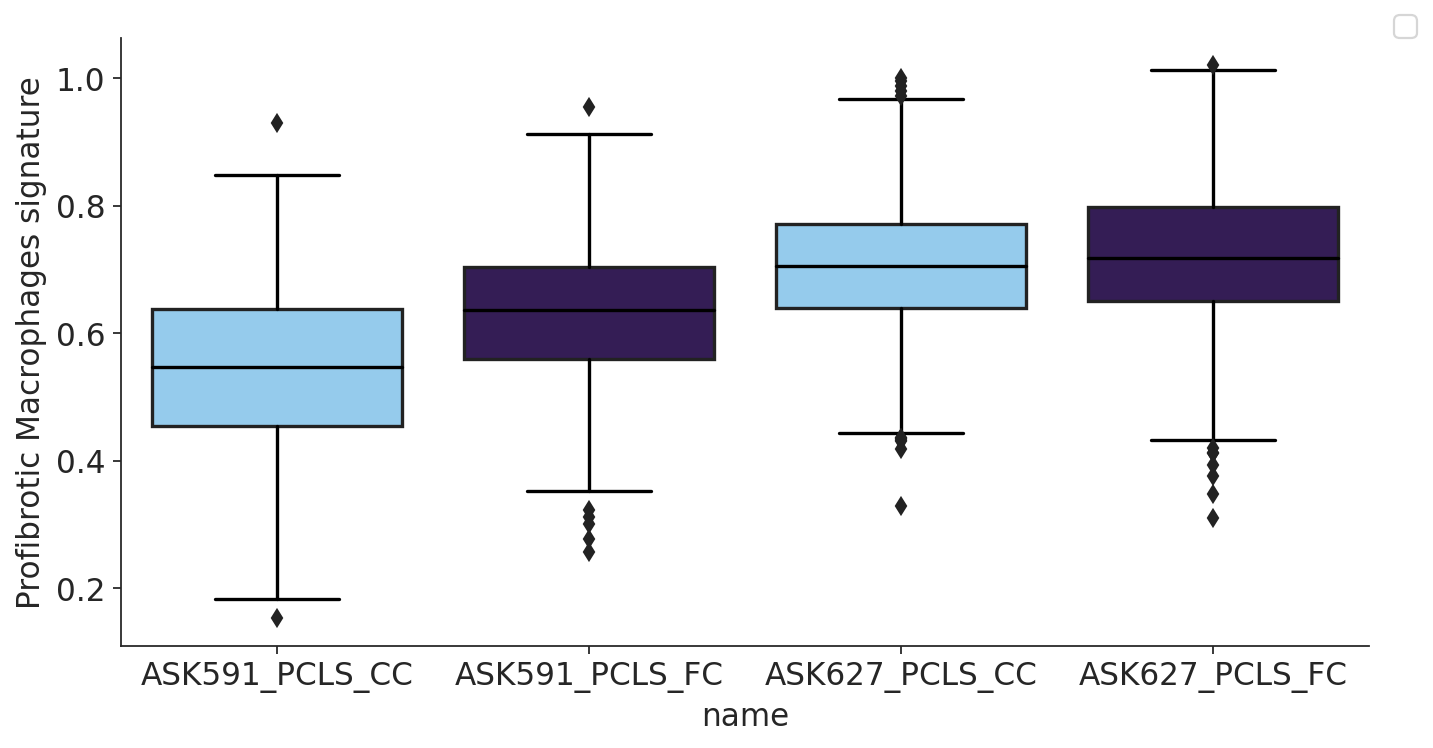

In [38]:
xlabel = 'name'
cols = macs.uns['%s_colors' %'treatment']
score = sc.get.obs_df(macs, keys = [s_name, xlabel], layer = None, use_raw = True)
sct.plot.gene_boxplot(score, score = s_name, xlabel = xlabel, figsize = (10, 5), palette = cols, width = 0.8,
                      save = fig_dir + 'boxplot_profibrotic_macrophage_score_treatment.pdf')

In [39]:
ask627_score_fc = score[score['name'].isin(['ASK627_PCLS_FC'])]['Profibrotic Macrophages signature'].to_list()
ask627_score_cc = score[score['name'].isin(['ASK627_PCLS_CC'])]['Profibrotic Macrophages signature'].to_list()
ask591_score_fc = score[score['name'].isin(['ASK591_PCLS_FC'])]['Profibrotic Macrophages signature'].to_list()
ask591_score_cc = score[score['name'].isin(['ASK591_PCLS_CC'])]['Profibrotic Macrophages signature'].to_list()

In [40]:
import scipy.stats as stats
#perform the Mann-Whitney U test for ASK591
stats.mannwhitneyu(ask591_score_cc, ask591_score_fc, alternative='two-sided')

MannwhitneyuResult(statistic=91952.0, pvalue=1.3976603962283136e-27)

In [41]:
#perform the Mann-Whitney U test for ASK627
stats.mannwhitneyu(ask627_score_cc, ask627_score_fc, alternative='two-sided')

MannwhitneyuResult(statistic=611998.0, pvalue=8.641284107546119e-05)

### Feature Plot of macrophage marker genes

In [42]:
mac_marker = ['SPP1','MMP9','CCL2','CHI3L1','MERTK']

In [43]:
from matplotlib import colors
grey_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N=128)

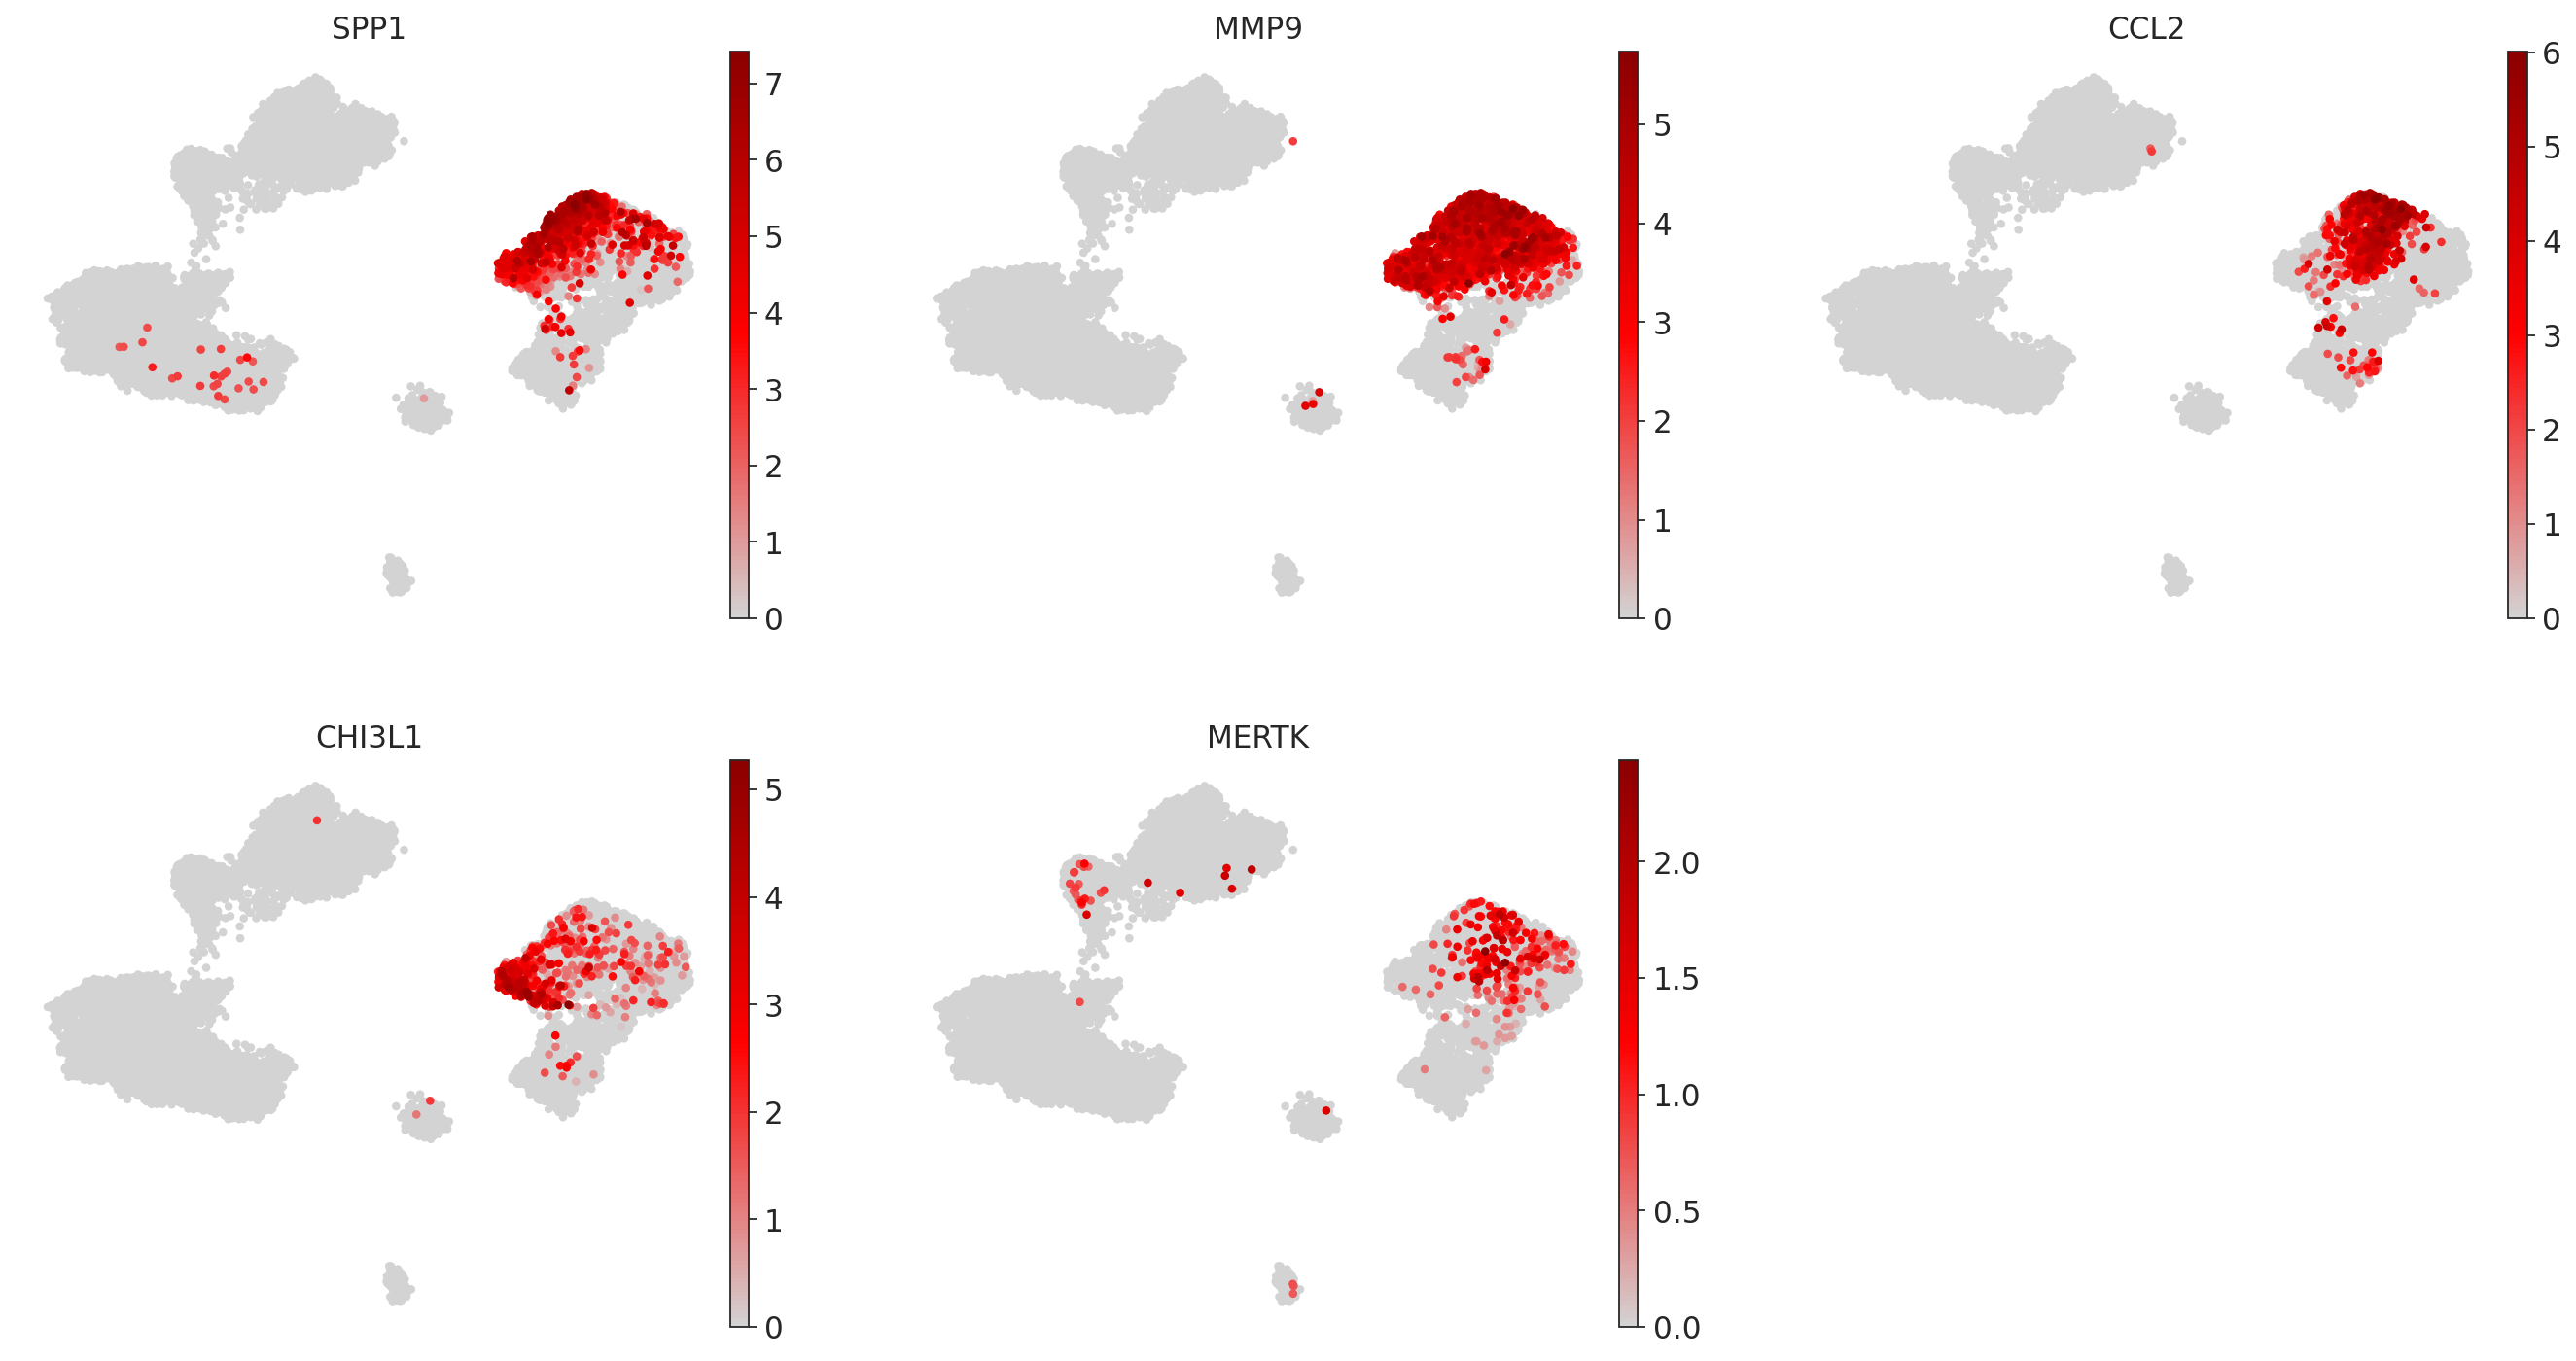

In [44]:
sc.pl.umap(adata, color =  mac_marker, frameon = False, cmap = grey_red, size = 60, vmin = 0, ncols = 3,
          save = '_mac_marker.pdf')

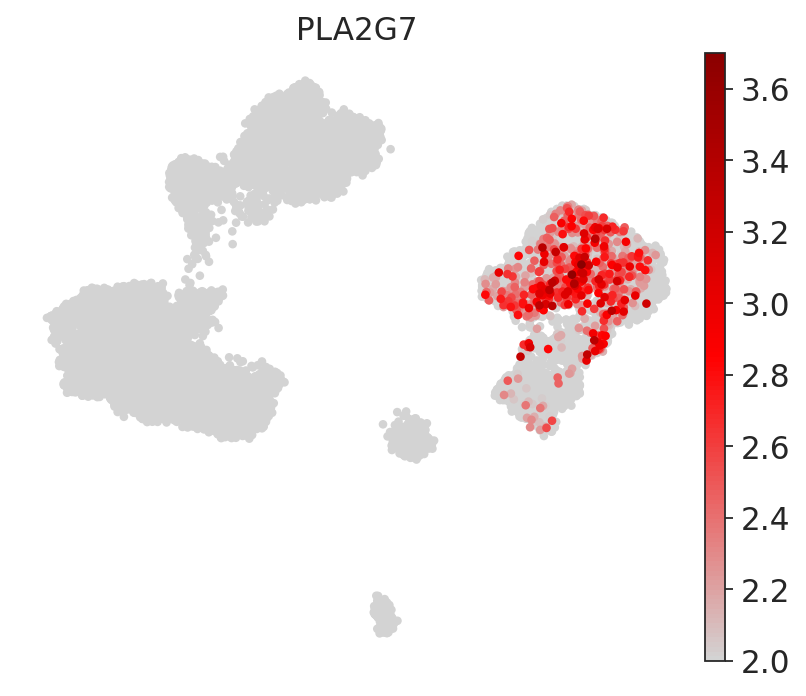

In [45]:
sc.pl.umap(adata, color = ['PLA2G7'], frameon = False, vmin = 2, cmap = grey_red, size = 60,
          save = '_PLA2G7.pdf')